In [8]:
# Energy Efficiency Dataset을 활용한 회귀 모델 구현 및 분석
# 목표: 냉난방 부하(연속형 변수)를 예측하는 회귀 모델을 구축하고 성능 평가 및 최적화하는 과정

# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
# 2. 데이터 불러오기
# Kaggle에서 제공하는 Energy Efficiency Dataset을 읽어온다.
df = pd.read_csv("energy_efficiency_data.csv")

In [10]:
# 3. 데이터 확인 및 전처리
# 컬럼명 앞뒤 공백 제거 및 필요 없는 열 제거
# Heating Load (Y1), Cooling Load (Y2) 중 Cooling Load를 예측 대상으로 설정
df.columns = df.columns.str.strip()
df = df.drop(columns=[col for col in df.columns if "Unnamed" in col])

In [11]:
# 4. 피처 및 타겟 분리
# 입력 특성(X)과 목표 변수(y) 분리
df_features = df.iloc[:, :-2]  # 입력 특성 (0~7번째 열)
df_target = df.iloc[:, -1]     # Cooling Load (마지막 열)

X = df_features
y = df_target

In [12]:
# 5. 데이터 분할
# 학습 데이터와 테스트 데이터로 8:2 비율로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# 6. 스케일링
# 특성(feature)들을 표준화(StandardScaler)를 통해 평균 0, 분산 1로 변환
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# 7. 베이스라인 모델 학습: Linear Regression
# 가장 기본적인 선형 회귀 모델을 학습하여 성능을 비교할 기준(Baseline)으로 삼는다.
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# 베이스라인 모델로 예측 수행
y_pred_lr = lr.predict(X_test_scaled)

# 베이스라인 모델 성능 평가 (RMSE, MAE, R²)
print("Linear Regression Performance")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression Performance
RMSE: 3.1453819558114193
MAE: 2.1952952105158743
R2 Score: 0.8932255268607289


In [15]:
# 8. 고급 모델 학습: Random Forest Regressor
# 비선형성과 복잡한 상호작용을 잡기 위한 앙상블 기법(RandomForest) 적용
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Random Forest 모델로 예측 수행
y_pred_rf = rf.predict(X_test_scaled)

# Random Forest 모델 성능 평가
print("\nRandom Forest Performance")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest Performance
RMSE: 1.7256294624160873
MAE: 1.072605194805194
R2 Score: 0.9678622291947366


In [16]:
# 9. 하이퍼파라미터 튜닝
# Random Forest의 성능을 높이기 위해 GridSearchCV를 사용하여 최적 파라미터 탐색
param_grid = {
    'n_estimators': [100, 200], # 트리 개수
    'max_depth': [5, 10, None], # 최대 깊이
    'min_samples_split': [2, 5, 10] # 노드 분할 최소 샘플 수
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5, # 5-Fold 교차 검증
    n_jobs=-1
)

# 최적의 하이퍼파라미터를 찾기 위해 학습
grid_search.fit(X_train_scaled, y_train)
print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [17]:
# 10. 튜닝된 모델로 최종 평가
# 최적 하이퍼파라미터를 적용한 모델을 테스트 데이터에 적용해 성능 평가
y_pred_best = grid_search.best_estimator_.predict(X_test_scaled)

print("\nTuned Random Forest Performance")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("R2 Score:", r2_score(y_test, y_pred_best))


Tuned Random Forest Performance
RMSE: 1.767771485167773
MAE: 1.0977739654194962
R2 Score: 0.9662733734592577


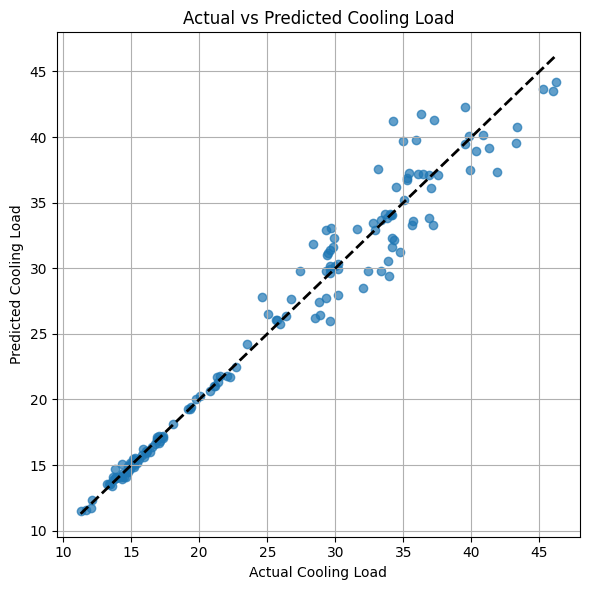

In [18]:
# 11. 예측 결과 시각화
# 실제값과 예측값을 산점도로 비교하여 모델 예측의 적합도를 시각적으로 확인
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Cooling Load")
plt.ylabel("Predicted Cooling Load")
plt.title("Actual vs Predicted Cooling Load")
plt.grid()
plt.tight_layout()
plt.show()